In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
# Cancel this cell if you want to re-run the code

import os

cwd = os.getcwd()
figure = '/Exam'

cwd + figure

'C:\\Users\\Jerome Romano\\Numerical Methods/Exam'

#### 1. Defining the model parameters
The model parameters are calibrated to match the literature. All the related explanations can be found on the pdf, including the meaning and the role of each parameter.

In [3]:
### All the parameters are collected in a dictionary

parameters = pd.Series(dtype=float)

parameters['beta'] = 0.9943  # Discount factor, representing the preference for future consumption
parameters['sigma_ss'] = 3.12 #Steady state elasticity of loan demand
parameters['alpha'] = 2  # Inverse of the Frish elasticity
parameters['A'] = 1.00  # Initial value of the exogenous technology variable
parameters['rho_a'] = 0.963  # Technology correlation coefficient
parameters['rho_sigma'] = 0.82 #Loan demand elasticity correlation coefficient
parameters['psi'] = 0.77 #Policy rate persistence
parameters['gamma'] = 0.35 #Output weight in the Taylor rule
parameters['delta'] = 2.01  # Final good price weight in the Taylor rule
parameters['eta'] = 1.00  # Elasticity of intertemporal substitution in consumption
parameters['s_a'] = 0.006 #Technology level standard deviation
parameters['s_sigma'] = 0.063 #Loan demand elasticity standard deviation


#### 2. Defining the model non-linear system of equations

This block is the key to the solution of the model.

In the following Python function, I collect all the equations describing the model that make up the non-linear system. The function takes as arguments the variable (both forward, i.e. $x_{t+1}$, and current, i.e. $x_t$) plus the dictionary of parameters, returning an array with the values of each of those equations.

Notice that this is the reduced system, meaning that I have substituted out some variables to reduce dimensionality. The relative explanation can be found in the pdf.

In [4]:
def equilibrium_equations(variables_forward, variables_current, parameters):
    
    # Parameters
    p = parameters

    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Consumers' constraint
    cons_constr = -(1 + cur.r) * cur.d + fwd.c * (fwd.n ** p.alpha) * fwd.p + (fwd.K * fwd.r) / (fwd.sigma - 1) - fwd.p * fwd.c + fwd.d
    
    # Euler equation
    euler = p.beta * ((1 + fwd.r) * (1 / (fwd.p * fwd.c))) - (1 / (cur.p * cur.c))
    
    # Labour demand
    lab_dem = ((1 / (cur.n ** (p.alpha - 1) * cur.c)) ** cur.sigma) * (((cur.a * cur.n) ** ((cur.sigma - 1) / cur.sigma) + cur.K ** ((cur.sigma - 1) / cur.sigma)) ** (cur.sigma / (cur.sigma - 1))) * (cur.a ** (cur.sigma - 1)) - cur.n
    
    # Capital demand
    cap_dem = ((cur.p / ((cur.sigma / (cur.sigma - 1)) * cur.r)) ** cur.sigma) * (((cur.a * cur.n) ** ((cur.sigma - 1) / cur.sigma) + cur.K ** ((cur.sigma - 1) / cur.sigma)) ** (cur.sigma / (cur.sigma - 1))) - cur.K
    
    # Price level
    price = (((cur.sigma / (cur.sigma - 1)) * cur.r) ** (1 - cur.sigma) + ((cur.c * cur.n ** (p.alpha - 1) * cur.p / cur.a) ** (1 - cur.sigma))) ** (1 / (1 - cur.sigma)) - cur.p
    
    # Taylor rule
    taylor = (((1 - p.beta) / p.beta) ** (1 - p.psi)) * (cur.r ** p.psi) * ((fwd.p / cur.p) ** (p.delta * (1 - p.psi))) * (((((fwd.a * fwd.n) ** ((fwd.sigma - 1) / fwd.sigma) + fwd.K ** ((fwd.sigma - 1) / fwd.sigma)) ** (fwd.sigma / (fwd.sigma - 1))) / (((cur.a * cur.n) ** ((cur.sigma - 1) / cur.sigma) + cur.K ** ((cur.sigma - 1) / cur.sigma)) ** (cur.sigma / (cur.sigma - 1)))) ** (p.gamma * (1 - p.psi))) - fwd.r
    
    # Technology
    tech = cur.a ** p.rho_a - fwd.a
    
    # Sigma
    sigma = p.sigma_ss ** (1 - p.rho_sigma) * cur.sigma ** p.rho_sigma - fwd.sigma
    
    return np.array([
            cons_constr,
            euler,
            lab_dem,
            cap_dem,
            price,
            taylor,
            tech,
            sigma
        ])

#### 3. Evaluating the model in the steady state

To find the steady state of the non-linear system I followed a mixed analytical-numerical approach.

In particular, it is easy to notice that since the value of the policy rate, technology level and loan demand elasticity in the steady state are exogenously given, there is no need to include those equations in the system evaluated in its equilibrium. This allows to reduce further the system from 8 to 5 equations.

Plugging then the equilibrium values for $r, A$ and $\sigma$ in the remaining equations, I proceed numerically to find the steady state values of $K, c, n, d$ and $p$. 

In [5]:
# I restate the values of each of the parameters

β = 0.9943
σ_ss = 3.12
α = 2.00
A_0 = 1.00
ρ_A = 0.936
ρ_σ = 0.820
γ = 0.35
δ = 2.01
ψ = 0.77

Now I redefine the non-linear system (reduced only to those variables for which the steady state is yet to be determined) in the steady state. In this sense all variables take the form $x_{t+1} = x_t = \bar{x}$.

In [6]:
def system(variables):
    
    K, c, n, d, p, sigma = variables
    
    r = (1 - β) / β   # Steady state value of the policy rate
    
    x1 = -(1 + r) * d + c * (n ** α) * p + (K * r) / (σ_ss - 1) - p * c + d
    
    x2 = β * ((1 + r) * (1 / (p * c))) - (1 / (p * c))
    
    x3 = ((1 / (n ** (α - 1) * c)) ** σ_ss) * (((A_0 * n) ** ((σ_ss - 1) / σ_ss) + K ** ((σ_ss - 1) / σ_ss))) ** (σ_ss / (σ_ss - 1)) * (A_0 ** (σ_ss - 1)) - n
    
    x4 = ((p / ((σ_ss / (σ_ss - 1)) * r)) ** σ_ss) * (((A_0 * n) ** ((σ_ss - 1) / σ_ss) + K ** ((σ_ss - 1) / σ_ss))) ** (σ_ss / (σ_ss - 1)) - K
    
    x5 = (((σ_ss / (σ_ss - 1)) * r) ** (1 - σ_ss) + ((c * n ** (α - 1) * p / A_0) ** (1 - σ_ss))) ** (1 / (1 - σ_ss)) - p 
    
    x6 = σ_ss ** (1 - ρ_σ) * σ_ss ** ρ_σ - σ_ss
    
        
    return x1, x2, x3, x4, x5, x6

I plug first just arbitrary values to check that the Python function works properly.

In [7]:
trial = [1, 1, 1, 1, 1, 1]

system(trial)

(-0.003028583681702557,
 -1.1102230246251565e-16,
 1.7734815210410613,
 8191352.91956228,
 -0.9915633908782774,
 0.0)

Using the guess above, I now let Python find the correct steady state solution for the reduced system and I check that the solution is indeed correct.

Clearly, a steady state solution is an array of values for which the system defined above is made up of all zeroes.

In [8]:
sol = scipy.optimize.root(system, trial).x

### I plug the solution in the system and check that the result is an array of 0s.
result = np.round(system(sol), 10)

# Print the result
print(result)

[ 0.  0. -0.  0.  0.  0.]


In [9]:
# I give a look to the values. The array is: K, c, n, d, p

sol

array([5.21613589, 1.99443696, 0.97769077, 2.34685663, 0.0073997 ,
       1.        ])

These are the values of the remaining variables to be determined in the steady state.

#### 4. Model initialization

The model is now ready to be initialized. 

I set to 3 the number of predetermined variables, which will be automatically the first four described: $A, \sigma$ and $r$.

In [10]:
### All the features of the package are described at https://www.briancjenkins.com/linearsolve/docs/build/html/index.html

# Initialize the model

# Initialization requires:
#  1) the definition of the non-linear system;
#  2) the number of predetermined (state) variables;
#  3) the list of the variables making up the model;
#  4) a list of shocks (one for each state variable);
#  5) the list of parameters.

model = ls.model(equations = equilibrium_equations,
               n_states=3,
               n_exo_states=3,
               var_names=['a', 'sigma', 'r', 'K', 'd', 'c', 'p', 'n'],
               shock_names=['e_A', 'e_σ', 'e_r'], ### shock for the impulse response functions
               parameters=parameters)

I generate an array containing the steady state values obtained above and I check that it solve the larger non-linear system.

In [11]:
# I plug the entire steady state manually to further check that is the correct one

model.ss = {
    'a': 1.000000,
    'sigma': 3.12,
    'r': (1 - β) / β,  
    'K': 5.21613589,  
    'd': 2.34685663,
    'c': 1.99443696,
    'p': 0.0073997,
    'n': 0.97769077
}

model.ss = pd.Series(model.ss)

In [12]:
# Notice how, in correspondance of the steady state, all the equations of the model are extremely close to 0

equilibrium_equations(model.ss, model.ss, parameters)

array([ 5.17407450e-10, -1.42108547e-14, -9.89488069e-09, -1.00159222e-05,
        3.45442859e-09,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [13]:
model.set_ss([1, 3.12, (1 - β) / β, 5.21613589, 2.34685663, 1.99443696, 0.0073997, 0.97769077])

In [14]:
# This is the steady state of the model

model.ss

a        1.000000
sigma    3.120000
r        0.005733
K        5.216136
d        2.346857
c        1.994437
p        0.007400
n        0.977691
dtype: float64

The check is also confirmed through a built-in method of the package.

Notice that the only False is due to the tolerance of the method (which is very low): stil the first equation in the steady state is around 0.0001, so very close to 0.

In [15]:
model.check_ss()

[ True  True  True False  True  True  True  True]


#### 5. Log-linear approximation and state space representation

The package is able to log-linearly approximate the system around its steady state and to produce two matrices $A$ and $B$ so that the model can be written as:
$$A \mathbb{E}[x_{t+1}] = B x_t$$

The description of how the state space representation is obtained can be found in the pdf. In particular, the procedure consists in implementing in Python the algorithm descibed in Chapter 2 of "Structural Macroeconometrics" by DeJong and Dave.

While I do not implement all the steps myself, it is important to notice that this routine is entirely built on that literature.

In [16]:
### First, all the equations are log-linearized around the steady state

model.log_linear_approximation()

In [17]:
### Then, the matrices A and B are computed, so that:
#  - A collects the derivative of the log-linearized equations w.r.t. the forward variables holding the current ones fixed at the steady state;
#  - B collects the derivative of the log-linearized equations w.r.t. the current variables holding the forward ones fixed at the steady state;

print('The matrix A:\n\n',np.around(model.a,4),'\n\n')
print('The matrix B:\n\n',np.around(model.b,4))

The matrix A:

 [[ 0.00000e+00 -2.08000e-02  1.41000e-02  1.41000e-02  2.34690e+00
  -7.00000e-04 -7.00000e-04  2.82000e-02]
 [ 0.00000e+00  0.00000e+00  3.86200e-01  0.00000e+00  0.00000e+00
  -6.77588e+01 -6.77588e+01  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.00000e-04 -2.00000e-04 -5.70000e-03  3.00000e-04  0.00000e+00
   0.00000e+00  2.70000e-03  1.00000e-04]
 [-1.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00 -3.12000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]] 


The matrix B:

 [[-0.00000e+00 -0.00000e+00  1.35000e-02 -0.00000e+00  2.36030e+00
  -0.00000e+00 -0.00000e+

#### 6. Solution of the system through the Klein's method

The model can now be solved by applying the Klein method, again through a built-in method of the package.

I weighed the decision of using the algorithm provided during the course. This was indeed my preferred way forward; however, the code keep producing floating-point errors, forcing me to rely on the package described above.

In [18]:
# Solve the model
model.solve_klein(model.a,model.b)

# Display the output

# The output consists again in two matrices:
# - matrix F describes the policy function, mapping current states into current controls (jumping variables);
# - matrix P describes the transition function, mapping current states into forward states.

print('The matrix F:\n\n',np.around(model.f,4),'\n\n')
print('The matrix P:\n\n',np.around(model.p,4))

The matrix F:

 [[-0.45   -1.1071  0.9987]
 [ 0.0538 -0.1059  0.0123]
 [ 0.1428  0.2179 -1.0052]
 [-0.1444 -0.2234  0.9996]
 [ 0.4066 -1.0281  1.004 ]] 


The matrix P:

 [[0.963  0.     0.    ]
 [0.     0.82   0.    ]
 [0.0054 0.0873 0.4971]]


The first two rows of matrix $P$ describe the law of motion of, respectively, $A_t$ and $\sigma_t$. Notice how they exactly retrace the AR(1) process that I assumed in the model: this is proof that the solution is indeed correct.

#### 7a. Impulse response function: financial shock

I now move to the final part of the work, the impulse response functions for each of the state variables. 

I will again rely on a built-in method of the package, taking advantage of the early definition (during the initialization of the model) of the three shocks. 

In [19]:
### The financial shock is calibrated to be equal to 1 standard deviation in magnitude, a quanitity defined in the pdf

model.impulse(T=30,t0=0,shocks=[0,0.0196875], percent=True)

In [20]:
# A dictionary tracks the movement in the variables 

print('Impulse responses to a 0.01 unit shock to σ:\n\n',model.irs['e_σ'].head())

Impulse responses to a 0.01 unit shock to σ:

        e_σ             a     sigma         r         K         d         c  \
0  1.96875  0.000000e+00  1.968750  0.000000 -2.179528 -0.208498  0.428927   
1  0.00000  4.439808e-16  1.614375  0.171853 -1.615579 -0.168860  0.178968   
2  0.00000  7.916177e-16  1.323787  0.226356 -1.239447 -0.137417  0.060871   
3  0.00000  1.060861e-15  1.085506  0.228086 -0.973927 -0.112161  0.007218   
4  0.00000  1.266406e-15  0.890115  0.208146 -0.777531 -0.091713 -0.015307   

          p         n  
0 -0.439749 -2.024147  
1 -0.188811 -1.487266  
2 -0.069424 -1.133784  
3 -0.014471 -0.887061  
4  0.009241 -0.706191  


I will also simulate changes in both the loan rate $R_t$ and in the wage $w_t$.

To accomplish this goal I simply log-linearize their respective equations, which could be found in the pdf section describing the model.

In [21]:
r_ss = (1 - β) / β

model.irs['e_σ']['R'] = (- 1 / (σ_ss - 1)) * model.irs['e_σ']['sigma'] + model.irs['e_σ']['r']

model.irs['e_σ']['w'] = model.irs['e_σ']['c'] + model.irs['e_σ']['p'] + (α - 1) * model.irs['e_σ']['n']

In [22]:
model.irs['e_σ'].head()

,e_σ,a,sigma,r,K,d,c,p,n,R,w
0,1.96875,0.000000e+00,1.968750,0.000000,-2.179528,-0.208498,0.428927,-0.439749,-2.024147,-0.928656,-2.034969
1,0.00000,4.439808e-16,1.614375,0.171853,-1.615579,-0.168860,0.178968,-0.188811,-1.487266,-0.589644,-1.497109
2,0.00000,7.916177e-16,1.323787,0.226356,-1.239447,-0.137417,0.060871,-0.069424,-1.133784,-0.398072,-1.142337
3,0.00000,1.060861e-15,1.085506,0.228086,-0.973927,-0.112161,0.007218,-0.014471,-0.887061,-0.283945,-0.894313
4,0.00000,1.266406e-15,0.890115,0.208146,-0.777531,-0.091713,-0.015307,0.009241,-0.706191,-0.211719,-0.712256


Finally, these changes are plotted, to give a precise look at them.

#### !!! If you re-run the code, put an # in front of the command "plt.savefig(cwd + figure + '/irf_finance')" so not to show an error !!!

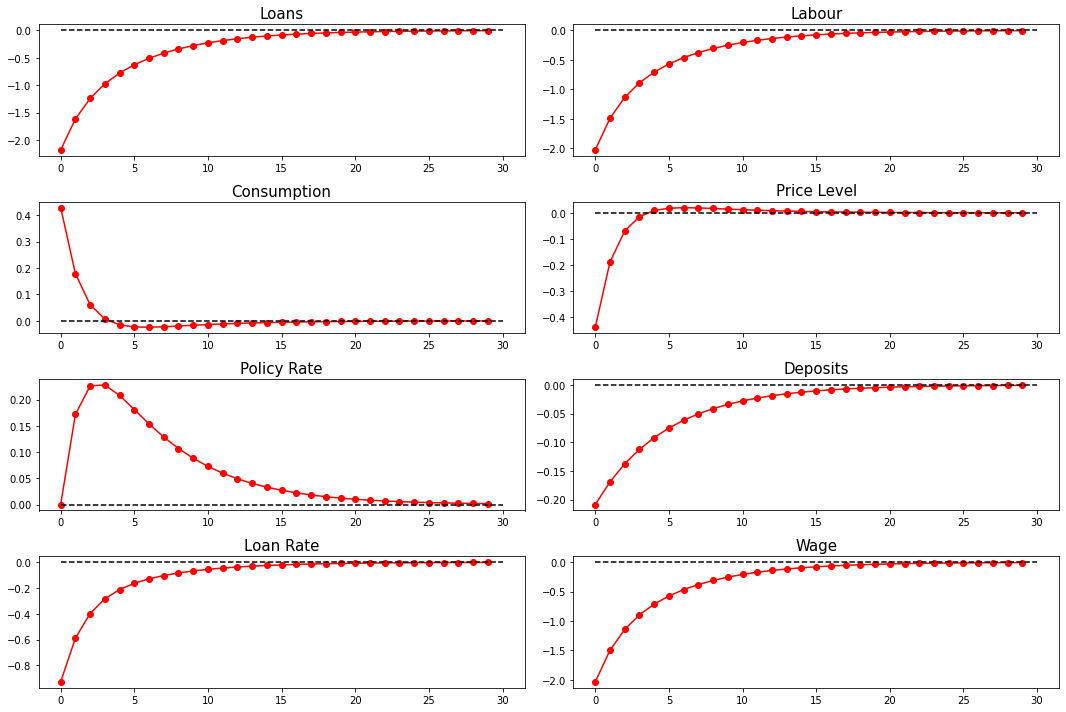

In [23]:
T = 30
variables = ['K', 'n', 'c', 'p', 'r', 'd', 'R', 'w']
titles = [r'Loans', r'Labour', r'Consumption', r'Price Level', r'Policy Rate', r'Deposits', \
          r'Loan Rate', r'Wage']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for (i, variable, title) in list(zip(axes, variables, titles)):
    i.plot(model.irs['e_σ'][variable], 'o-', color = 'red')
    i.set_title(title, fontsize = 15)
    i.hlines(0, 0, T, 'k', linestyle='dashed')
 

fig.tight_layout()

plt.savefig('irf_technology_0')

plt.show()


#### 7b. Impulse response function: technological shock

Following the exact same passages I now study the impulse response function following a technological shock.

In [24]:
model.impulse(T=30,t0=0,shocks=[0.006,0], percent=True)

In [25]:
print('Impulse responses to a 0.01 unit shock to A:\n\n',model.irs['e_A'].head())

Impulse responses to a 0.01 unit shock to A:

    e_A         a  sigma         r         K         d         c         p  \
0  0.6  0.600000    0.0  0.000000 -0.269999  0.032286  0.085678 -0.086670   
1  0.0  0.577800    0.0  0.003239 -0.256775  0.031131  0.079252 -0.080226   
2  0.0  0.556421    0.0  0.004729 -0.245666  0.029999  0.074701 -0.075648   
3  0.0  0.535834    0.0  0.005354 -0.235777  0.028899  0.071133 -0.072049   
4  0.0  0.516008    0.0  0.005554 -0.226656  0.027834  0.068101 -0.068985   

          n  
0  0.243955  
1  0.238180  
2  0.230984  
3  0.223241  
4  0.215381  


In [26]:
r_ss = (1 - β) / β

model.irs['e_A']['R'] = (- 1 / (σ_ss - 1)) * model.irs['e_A']['sigma'] + model.irs['e_A']['r']

model.irs['e_A']['w'] = model.irs['e_A']['c'] + model.irs['e_A']['p'] + (α - 1) * model.irs['e_A']['n']

In [27]:
#### !!! If you re-run the code, put an # in front of the command "plt.savefig(cwd + figure + '/irf_technology')" so not to show an error !!!

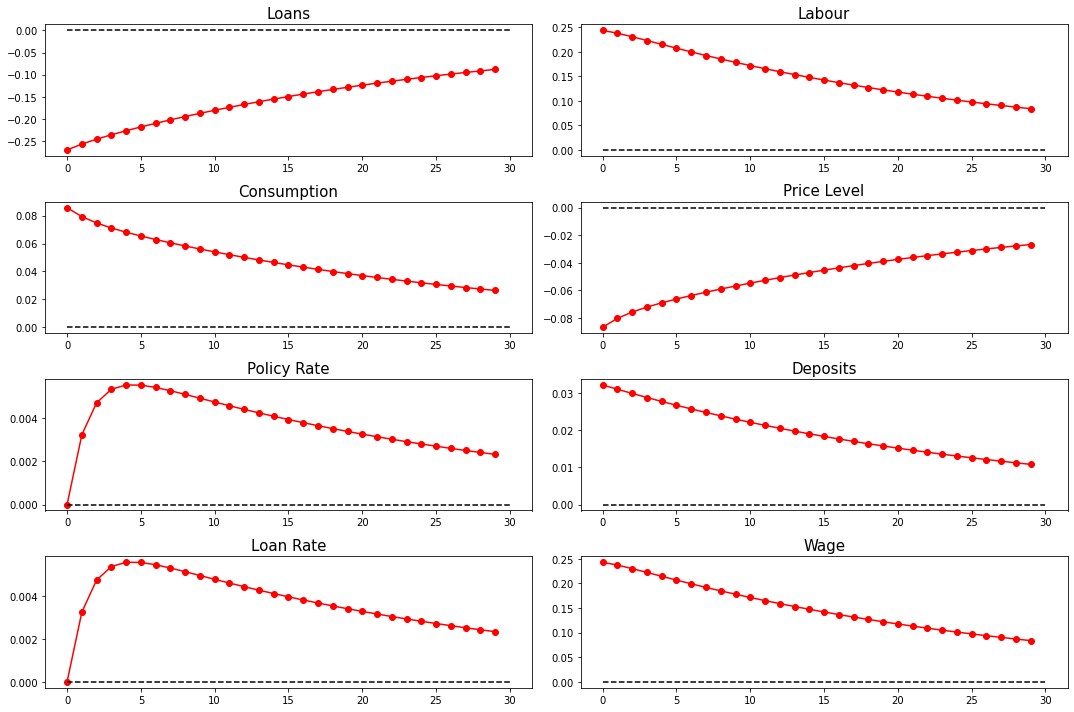

In [28]:
T = 30
variables = ['K', 'n', 'c', 'p', 'r', 'd', 'R', 'w']
titles = [r'Loans', r'Labour', r'Consumption', r'Price Level', r'Policy Rate', r'Deposits', \
          r'Loan Rate', r'Wage']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for (i, variable, title) in list(zip(axes, variables, titles)):
    i.plot(model.irs['e_A'][variable], 'o-', color = 'red')
    i.set_title(title, fontsize = 15)
    i.hlines(0, 0, T, 'k', linestyle='dashed')
 

fig.tight_layout()

#plt.savefig(cwd + figure + '/irf_technology')

plt.show()

#### 7c. Impulse response function: monetary policy tightening

Finally, I investigate the impulse response functions following a contractionsary monetary policy shock.

In [29]:
model.impulse(T=30,t0=0,shocks=[0,0, 0.005], percent = True)

In [30]:
print('Impulse responses to a 0.01 unit shock to A:\n\n',model.irs['e_r'].head())

Impulse responses to a 0.01 unit shock to A:

    e_r    a  sigma         r         K         d         c         p         n
0  0.5  0.0    0.0  0.500000  0.499363  0.006135 -0.502614  0.499797  0.501979
1  0.0  0.0    0.0  0.248572  0.248256  0.003050 -0.249872  0.248471  0.249556
2  0.0  0.0    0.0  0.123577  0.123419  0.001516 -0.124223  0.123526  0.124066
3  0.0  0.0    0.0  0.061435  0.061357  0.000754 -0.061757  0.061410  0.061679
4  0.0  0.0    0.0  0.030542  0.030503  0.000375 -0.030702  0.030530  0.030663


In [31]:
r_ss = (1 - β) / β

model.irs['e_r']['R'] = (- 1 / (σ_ss - 1)) * model.irs['e_r']['sigma'] + model.irs['e_r']['r']

model.irs['e_r']['w'] = model.irs['e_r']['c'] + model.irs['e_r']['p'] + (α - 1) * model.irs['e_r']['n']

#### !!! If you re-run the code, put an # in front of the command "plt.savefig(cwd + figure + '/irf_interest')" so not to show an error !!!

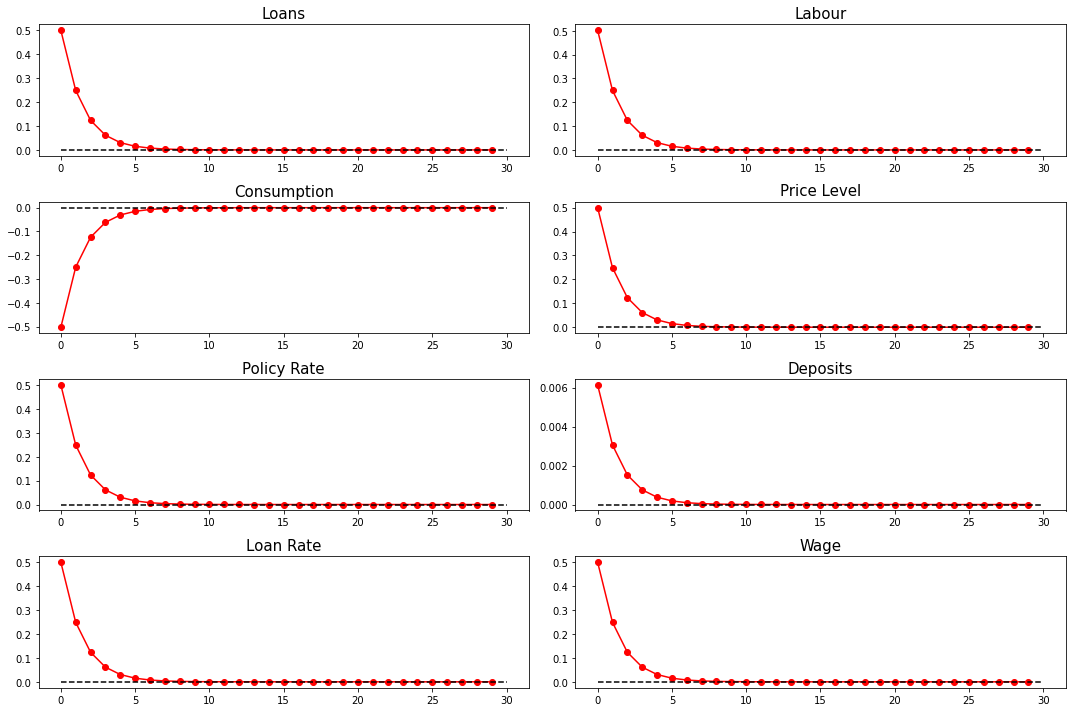

In [32]:
T = 30
variables = ['K', 'n', 'c', 'p', 'r', 'd', 'R', 'w']
titles = [r'Loans', r'Labour', r'Consumption', r'Price Level', r'Policy Rate', r'Deposits', \
          r'Loan Rate', r'Wage']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for (i, variable, title) in list(zip(axes, variables, titles)):
    i.plot(model.irs['e_r'][variable], 'o-', color = 'red')
    i.set_title(title, fontsize = 15)
    i.hlines(0, 0, T, 'k', linestyle='dashed')
 

fig.tight_layout()

#plt.savefig(cwd + figure + '/irf_interest')

plt.show()

#### 8. References (to be found also in the pdf)

- DeJong, David N and Chetan Dave (2011), Structural macroeconometrics, Princeton University Press.
- Jenkins, Brian C (2019), Linearsolve, https://www.briancjenkins.com/ linearsolve/docs/build/html/index.html.
- Klein, Paul (2000), «Using the generalized Schur form to solve a multivariate linear rational expectations model», Journal of economic dynamics and control, 24, 10, pp. 1405-1423.